In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma, norm

%matplotlib inline

## Generate Gaussian data

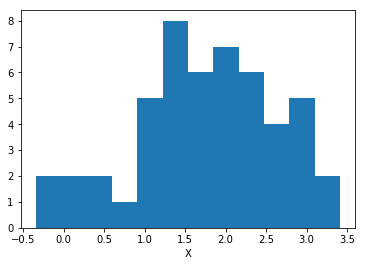

In [2]:
# set parameters for prior 
prior_mu = 2. 
prior_sigma = 4. 

# set true mean
true_mu = 2.

N = 50
X_o = np.random.normal(loc=true_mu, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins=12);
plt.xlabel('X');

In [3]:
class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.alpha_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softmax())
        self.logsigma_out = nn.Linear(n_hidden, n_components)
        self.mu_out = nn.Linear(n_hidden, n_components)  

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_alpha = self.alpha_out(act)
        out_sigma = torch.exp(self.logsigma_out(act))
        out_mu = self.mu_out(act)
        return (out_alpha, out_sigma, out_mu)

In [4]:
# this one is used to approximate the posterior with a mixture of Gaussians 
def gauss_pdf(y, mu, sigma, log=False):
    result = -0.5*torch.log(2*np.pi*sigma**2) - 1/(2*sigma**2) * (y.expand_as(mu) - mu)**2
    if log:
        return result
    else: 
        return torch.exp(result)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_alpha, out_sigma, out_mu, y):
    result = (gauss_pdf(y, out_mu, out_sigma, log=True) * out_alpha).squeeze()
    result = torch.mean(result)  # mean over batch
    return -result

In [5]:
# we need to define a generative model to generate samples (theta, x)
def generate_dataset(N, m):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(N): 
        # sample from the prior 
        theta = np.random.normal(prior_mu, prior_sigma)

        # generate samples
        x = np.random.normal(theta, size=m)
        
        # as data we append the summary stats
        X.append(calculate_stats(x).astype(float)) 
        thetas.append([theta])
    
    return np.array(X), np.array(thetas)

# calculate summary stats, for poisson this is just x, so for a vector it is sum x
def calculate_stats(x): 
    sx = np.array([np.mean(x).astype(float)])
#    sx = x
    return sx

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

In [6]:
model = MDN_phi(ndim_input=1, n_components=1)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))


In [7]:
X, Y = generate_dataset(300, N)

In [8]:
train(X, Y, n_epochs=500)

[epoch 0050] loss: -0.1033
[epoch 0100] loss: -0.5560
[epoch 0150] loss: -0.5152
[epoch 0200] loss: -0.5372
[epoch 0250] loss: -0.5416
[epoch 0300] loss: -0.3930
[epoch 0350] loss: -0.4812
[epoch 0400] loss: -0.5094
[epoch 0450] loss: -0.4139
[epoch 0500] loss: -0.4920


In [9]:
# now evaluate the model at the observed data 
stats_o = calculate_stats(X_o).reshape(1, 1)

X_var = Variable(torch.Tensor(stats_o))

(out_alpha, out_sigma, out_mu) = model(X_var)

In [10]:
thetas = np.linspace(0, 10, 100)

post = []

for y in thetas: 
    y = Variable(torch.Tensor(np.array(y).reshape(1, 1)))
    th = (gauss_pdf(y, out_mu, out_sigma, log=False) * out_alpha).sum()
    post.append(th.data.numpy())
post = np.array(post).squeeze()
prior = norm.pdf(thetas, loc=prior_mu, scale=prior_sigma)

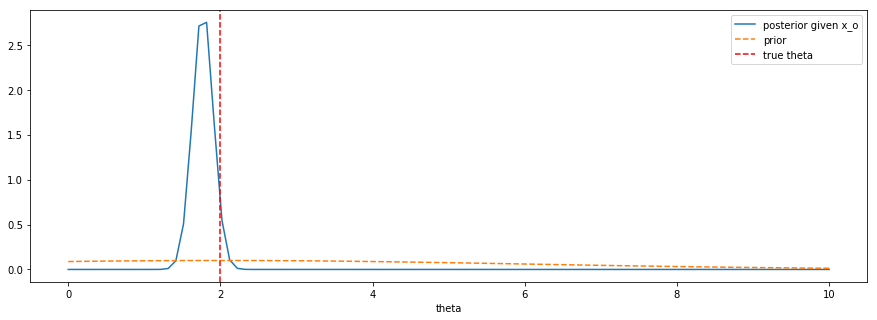

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post.squeeze(), label='posterior given x_o')
plt.plot(thetas, prior, '--', label='prior')
plt.axvline(x=true_mu, label='true theta', linestyle='--', color='r')
plt.xlabel('theta')
plt.legend();